### Import the necessary library

In [36]:
import requests                 # for making HTTP requests
import csv                      # for reading CSV files
import pandas as pd             # for data manipulation
import matplotlib.pyplot as plt # for plotting data

from io import StringIO                 # for reading string inputs
from wordcloud import WordCloud         # for generating word clouds
from nltk.tokenize import word_tokenize # for tokenizing words

### A Bunch of function to be used

In [2]:
def get_data(url:str, words: dict = {}):
    """reads the data from the url and stores it in a dictionary

    Args:
        url (str): the url of the data
        words (dict, optional): the variable to store the words. Defaults to {}.

    Returns:
        dict: the dictionary containing the words
    """
    # read the data from the url
    response = requests.get(url)
    # check if the response is successful
    if response.status_code == 200:
        # read the data from the response
        reader = csv.reader(StringIO(response.text), delimiter=",")
        # store the data in the dictionary
        for row in reader:
            words[row[0]] = int(row[1])
    else:
        print("Error")
    return words

In [17]:
def count_sentiment(text: str,
                lexicon_plus: dict, lexicon_minus: dict):
    """counts the sentiment of the text

    Args:
        text (str): the text to be analyzed
        lexicon_plus (dict): the positive lexicon
        lexicon_minus (dict): the negative lexicon

    Returns:
        int: the sentiment score
    """
    # initialize the score
    score = 0
    # tokenize the words in the text
    for word in word_tokenize(text):
        # check if the word is in the lexicon
        if word in lexicon_plus.keys():     # if the word is in the positive lexicon
            score += lexicon_plus[word]
        if word in lexicon_minus.keys():    # if the word is in the negative lexicon
            score += lexicon_minus[word]
    return score

In [4]:
def sentiment_label(score: int, threshold: int = 0):
    """labels the sentiment

    Args:
        score (int): the sentiment score
        threshold (int, optional): the threshold value. Defaults to 0.

    Returns:
        str: the sentiment label
    """
    # label the sentiment based on the score
    if score > threshold:   # if the score is greater than the threshold (positive)
        return "positive"
    elif score < threshold: # if the score is less than the threshold (negative)
        return "negative"
    else:                   # if the score is equal to the threshold (neutral)
        return "neutral"

### Implement the labeling

In [5]:
# the lexicon urls
url = {
    "positives": "https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv",
    "negatives": "https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv"
}
# get the positive and negative words from the lexicon
positives_words = get_data(url["positives"])
negatives_words = get_data(url["negatives"])

In [21]:
dataset = pd.read_csv("./data/processed_dataset.csv")
dataset.dropna(inplace=True)
dataset.sentiment_by_score = dataset.sentiment_by_score.apply(lambda x: x.lower())
print(f"the shape of the dataset is {dataset.shape}")
dataset.head(5)

the shape of the dataset is (1638, 3)


,content,score,sentiment_by_score
0,update fiturnya,3,neutral
1,halte lengkap tanda bus trans metro deli kompl...,2,negative
2,datang posisi tinggal puter cileunyi,1,negative
3,hallo kota manado sulawesi utara teman bus mak...,5,positive
4,tolong dishub sedia rute akomodasi teman bus j...,1,negative


In [22]:
dataset["sentiment_score"] = dataset.content.apply(count_sentiment, args=(positives_words, negatives_words))
dataset["sentiment_by_content"] = dataset.sentiment_score.apply(sentiment_label)
dataset.head(5)

,content,score,sentiment_by_score,sentiment_score,sentiment_by_content
0,update fiturnya,3,neutral,0,neutral
1,halte lengkap tanda bus trans metro deli kompl...,2,negative,-12,negative
2,datang posisi tinggal puter cileunyi,1,negative,-14,negative
3,hallo kota manado sulawesi utara teman bus mak...,5,positive,6,positive
4,tolong dishub sedia rute akomodasi teman bus j...,1,negative,-8,negative


In [23]:
dataset.to_csv("./data/labelled_dataset.csv", index=False)

In [31]:
summary_by_score = pd.DataFrame(dataset.groupby("sentiment_by_score").size()).reset_index().rename(columns={0: "count_score"}).sort_values(by="count_score", ascending=False)
summary_by_content = pd.DataFrame(dataset.groupby("sentiment_by_content").size()).reset_index().rename(columns={0: "count_content"}).sort_values(by="count_content", ascending=False)

In [34]:
summary_info = summary_by_score.merge(summary_by_content, left_on="sentiment_by_score", right_on="sentiment_by_content")
summary_info["gap"] = abs(summary_info["count_score"] - summary_info["count_content"])
summary_info

,sentiment_by_score,count_score,sentiment_by_content,count_content,gap
0,positive,938,positive,344,594
1,negative,540,negative,1118,578
2,neutral,160,neutral,176,16


(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

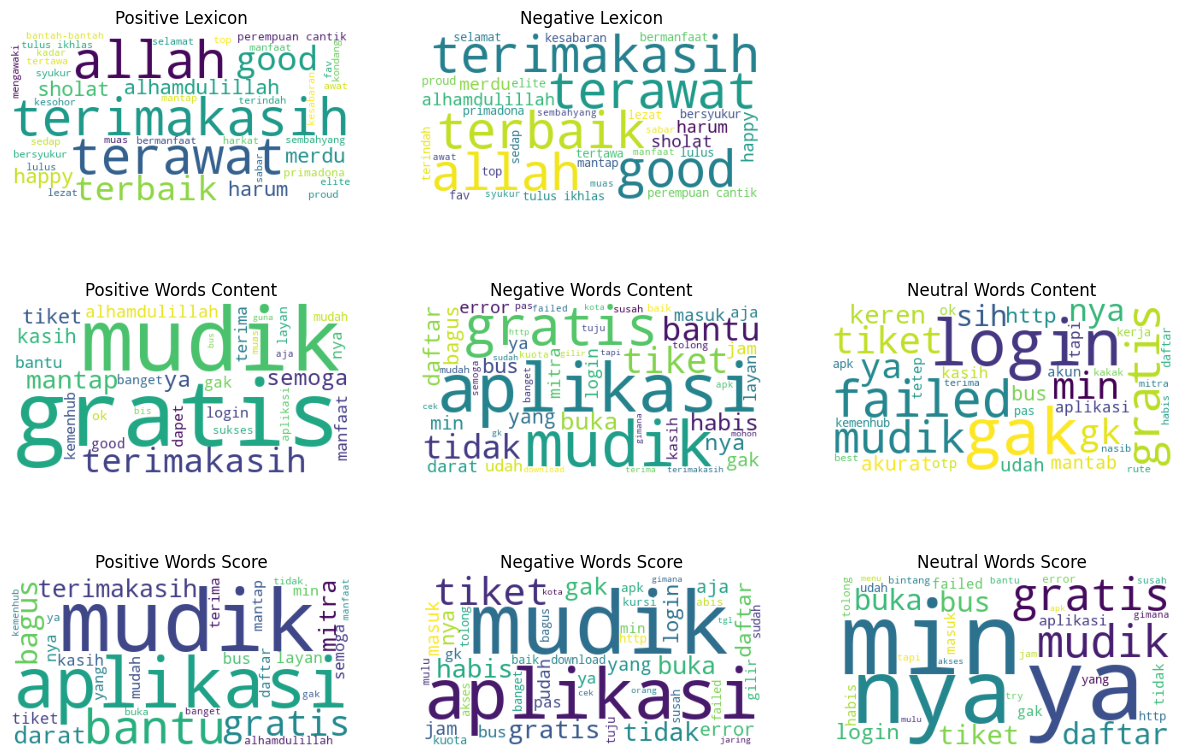

In [49]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1)
plt.imshow(WordCloud(background_color="white", min_font_size=10).generate_from_frequencies(positives_words))
plt.title("Positive Lexicon")
plt.axis("off")
plt.subplot(3, 3, 2)
plt.imshow(WordCloud(background_color="white", min_font_size=10).generate_from_frequencies(negatives_words))
plt.title("Negative Lexicon")
plt.axis("off")
plt.subplot(3, 3, 4)
plt.imshow(WordCloud(background_color="white", min_font_size=10).generate_from_frequencies(dataset.loc[dataset.sentiment_by_content == "positive", "content"].apply(word_tokenize).explode().value_counts().to_dict()))
plt.title("Positive Words Content")
plt.axis("off")
plt.subplot(3, 3, 5)
plt.imshow(WordCloud(background_color="white", min_font_size=10).generate_from_frequencies(dataset.loc[dataset.sentiment_by_content == "negative", "content"].apply(word_tokenize).explode().value_counts().to_dict()))
plt.title("Negative Words Content")
plt.axis("off")
plt.subplot(3, 3, 6)
plt.imshow(WordCloud(background_color="white", min_font_size=10).generate_from_frequencies(dataset.loc[dataset.sentiment_by_content == "neutral", "content"].apply(word_tokenize).explode().value_counts().to_dict()))
plt.title("Neutral Words Content")
plt.axis("off")
plt.subplot(3, 3, 7)
plt.imshow(WordCloud(background_color="white", min_font_size=10).generate_from_frequencies(dataset.loc[dataset.sentiment_by_score == "positive", "content"].apply(word_tokenize).explode().value_counts().to_dict()))
plt.title("Positive Words Score")
plt.axis("off")
plt.subplot(3, 3, 8)
plt.imshow(WordCloud(background_color="white", min_font_size=10).generate_from_frequencies(dataset.loc[dataset.sentiment_by_score == "negative", "content"].apply(word_tokenize).explode().value_counts().to_dict()))
plt.title("Negative Words Score")
plt.axis("off")
plt.subplot(3, 3, 9)
plt.imshow(WordCloud(background_color="white", min_font_size=10).generate_from_frequencies(dataset.loc[dataset.sentiment_by_score == "neutral", "content"].apply(word_tokenize).explode().value_counts().to_dict()))
plt.title("Neutral Words Score")
plt.axis("off")